In [1]:
########################################################################
# Author    : A. Alsema, J Kotah
# Date      : February 2024
# Dataset   : Visium Spatial Transcriptomics for MS lesions, slices with WM 
# Purpose   : cluster DEGs for a subtrajectory of pseudotime
# Output    : heatmap made from DEGs, corresponding to figure 6d, h, l
# Input     : subtrajectory objects as cds, csv file with DE results
########################################################################

rm(list = ls())

library(monocle3)
library(ggplot2)
library(dplyr)
library(ggplot2)
library(Matrix)
require(RColorBrewer)
require(gplots)
require(qpcR)
library(Matrix)

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading

### 1. Subtrajectory 1 (ends at rims)

#### Load in object and DEGs

In [2]:
setwd('/data/bcn/Datasets/ST_AAL_JK_WM/')
branch_name = "startnode_to_active_rim"
outdir = "/data/bcn/p310674/Documents/010_AAL_ST_Pseuodotime/Outputs/F_5-3_"
indir = "/data/bcn/Datasets/ST_AAL_JK_WM/Routput/monocle3/trajectory_DE/"

In [29]:
### load data
DEGs <- read.csv(paste0(indir, "1.DE_results_subtraj_4-4.startnode_to_rims-microglia_allgenes.csv"), row.names = 1)
head(DEGs)

cds <- readRDS("RData/monocle3/subtraj_4-4.startnode_to_rims-microglia_graph.rds")
#cds <- readRDS("RData/monocle3/subtraj_4-1.startnode_to_infl_graph.rds")
print("number of spots")
ncol(cds)


,status,p_value,morans_test_statistic,morans_I,gene_short_name,q_value
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
MIR1302-2HG,FAIL,NA,NA,NA,MIR1302-2HG,1.0000000
FAM138A,FAIL,NA,NA,NA,FAM138A,1.0000000
OR4F5,FAIL,NA,NA,NA,OR4F5,1.0000000
AL627309.1,OK,0.7017497,-0.5294394,-0.001144844,AL627309.1,0.7855827
AL627309.3,FAIL,NA,NA,NA,AL627309.3,1.0000000
AL627309.2,FAIL,NA,NA,NA,AL627309.2,1.0000000


[1] "number of spots"


[1] 16734

In [30]:
### select only significant genes
print("Filter significant DEGs")
DEGs <- DEGs[DEGs$status == "OK" , ] # optional. doesn't matter. all q-values < 0.01 have status OK
nrow(DEGs)
DEGs <- subset(DEGs, q_value < 0.001) 
print('with these thresholds, there are:')
nrow(DEGs)
print('significant DEGs')
DEGs <- DEGs[order(DEGs$morans_I, decreasing = TRUE),] #order

[1] "Filter significant DEGs"


[1] 23452

[1] "with these thresholds, there are:"


[1] 3237

[1] "significant DEGs"


#### Make heatmap with pseudotime bins 

In [31]:
# input is 500 significant DEGs, ordered by effect size
top_ids <- rownames(DEGs[1:500,])
top_ids

[1] "PLP1"       "MBP"        "APOC1"      "GPNMB"      "CNP"       
  [6] "FTL"        "C1QB"       "VIM"        "TF"         "CD74"      
 [11] "GJA1"       "CLU"        "TYROBP"     "APOE"       "AQP4"      
 [16] "HLA-DRA"    "A2M"        "HLA-DRB1"   "CTSB"       "MARCKSL1"  
 [21] "S100A11"    "CPE"        "TREM2"      "HLA-DPA1"   "C3"        
 [26] "CD68"       "TMSB10"     "APLP1"      "C1QC"       "CTSS"      
 [31] "MAFB"       "LPL"        "MAG"        "PPP1R14A"   "CLDND1"    
 [36] "FCER1G"     "LAPTM5"     "NUPR1"      "C1QA"       "MOBP"      
 [41] "IGFBP7"     "OLR1"       "LGALS3"     "AGT"        "HLA-DQB1"  
 [46] "HLA-B"      "IGHG3"      "ERMN"       "CHIT1"      "IGHG1"     
 [51] "ITGB2"      "HLA-DPB1"   "CD44"       "EFEMP1"     "SCD"       
 [56] "RNASET2"    "MOG"        "ASAH1"      "IGLC2"      "SPARCL1"   
 [61] "MAOB"       "KCTD12"     "MGST1"      "CHI3L1"     "AQP1"      
 [66] "CAPG"       "CYBA"       "ALOX5AP"    "CTSD"       "S100A6"    
 [71] "STMN1"      "CP"         "CTSC"       "ENPP2"      "CARNS1"    
 [76] "ANXA1"      "IGKC"       "B2M"        "HLA-DRB5"   "S100A10"   
 [81] "MSR1"       "STMN4"      "EDIL3"      "CNTN2"      "CD53"      
 [86] "HAPLN2"     "FCGR2A"     "HLA-E"      "ANXA2"      "MS4A6A"    
 [91] "SLC14A1"    "UGT8"       "HLA-C"      "GPM6A"      "TPT1"      
 [96] "DTNA"       "VSIG4"      "CRYAB"      "SLCO2B1"    "FCGR2B"    
[101] "CLDN11"     "WLS"        "TUBA1A"     "MT2A"       "ATP1A2"    
[106] "AEBP1"      "PLLP"       "SPP1"       "KLK6"       "CSF1R"     
[111] "CD37"       "SEPT4"      "ZFP36L1"    "CTSZ"       "CST3"      
[116] "GPR34"      "GRN"        "CEBPA"      "CXCL16"     "CPVL"      
[121] "RPL23"      "MS4A7"      "HLA-DMB"    "PSAP"       "APOD"      
[126] "IGLC3"      "ATP1B2"     "PTGDS"      "IFITM3"     "HLA-A"     
[131] "ITM2C"      "FXYD5"      "GYPC"       "ABCA1"      "FAM107A"   
[136] "AIF1"       "SLC1A3"     "NTRK2"      "CD99"       "HSPB1"     
[141] "TMEM144"    "CD163"      "TUBB4A"     "SOD2"       "CXCR4"     
[146] "DKK3"       "SIGLEC8"    "LTF"        "PABPC1"     "RPS19"     
[151] "TMIGD3"     "SCIN"       "RAPGEF5"    "SAT1"       "SRGN"      
[156] "C1S"        "S100B"      "GJB1"       "HSPA2"      "MAL"       
[161] "FLNA"       "DHCR24"     "SOX9"       "ITGB4"      "SIRT2"     
[166] "TNC"        "CHI3L2"     "CNN3"       "CEBPD"      "CFD"       
[171] "CDKN1C"     "S100A4"     "MLC1"       "DCLK1"      "TMEM151A"  
[176] "SEMA4D"     "ARHGDIB"    "CD14"       "CNDP1"      "FCGR3A"    
[181] "EMP1"       "RPS2"       "SERPING1"   "CYFIP1"     "NPC2"      
[186] "ITGAX"      "LRP1"       "SPOCK3"     "MARCKS"     "RGS10"     
[191] "SLC12A2"    "BACE1"      "GPX3"       "HLA-DMA"    "FEZ1"      
[196] "HSPB8"      "LGMN"       "RGS1"       "GPM6B"      "ELOVL1"    
[201] "PLEKHH1"    "TMSB4X"     "STOM"       "SEPT8"      "FA2H"      
[206] "LHPP"       "CMTM5"      "GFAP"       "LGALS9"     "PLPP3"     
[211] "C1R"        "MT1E"       "NEAT1"      "AHCYL1"     "APLNR"     
[216] "ABCA2"      "EEF1A1"     "RNASE1"     "RPL11"      "QDPR"      
[221] "ID3"        "METTL7A"    "SLC15A3"    "LY86"       "BCAS1"     
[226] "CD84"       "CAMK2N1"    "CCL2"       "CDC42EP4"   "GPR37"     
[231] "LYZ"        "SLAIN1"     "PBXIP1"     "S100A9"     "RPL29"     
[236] "CD81"       "LANCL1"     "ATP1B1"     "CLIC1"      "CEBPB"     
[241] "OGFRL1"     "NECAB1"     "AHNAK"      "PCSK6"      "AL031056.1"
[246] "ARRB2"      "CPM"        "RPS20"      "SLC7A7"     "RPL14"     
[251] "OPALIN"     "PLEKHB1"    "C3AR1"      "IGHG4"      "S100A8"    
[256] "BRI3"       "NEBL"       "SLC1A2"     "MYRF"       "PAQR6"     
[261] "AKR1B1"     "ST6GAL1"    "FCGRT"      "RPL27A"     "RPL39"     
[266] "HLA-DQA1"   "DAB2"       "PIP4K2A"    "LGALS1"     "LY6H"      
[271] "APLP2"      "SELENOP"    "CD59"       "SYNJ2"      "UNC93B1"   
[276] "TPPP"       "CD63"       "TMEM47"     "FCGR1A"     "CTNND2"    
[281] "SERPINE1"   "FGFR3"

In [32]:
# decision: which pseudotime breaks?
cds$pseudotime_bins <- cut(cds$Pseudotime, breaks = as.vector(seq(0,round(max(cds$Pseudotime)),1)))

# make a heatmap matrix
cell_group_df <- tibble::tibble(cell=row.names(colData(cds)), 
                                cell_group=cds$pseudotime_bins)
agg_mat <- aggregate_gene_expression(cds, gene_group_df = NULL, cell_group_df = cell_group_df)

dim(agg_mat)
agg_mat <- agg_mat[rownames(agg_mat) %in% top_ids ,]

# order the columns
agg_mat <- agg_mat[, match( levels(cds$pseudotime_bins), colnames(agg_mat))]
dim(agg_mat)
head(agg_mat)

[1] 33538    16

[1] 500  16

,"(0,1]","(1,2]","(2,3]","(3,4]","(4,5]","(5,6]","(6,7]","(7,8]","(8,9]","(9,10]","(10,11]","(11,12]","(12,13]","(13,14]","(14,15]","(15,16]"
ENO1,-0.7136317,-1.1132016,-0.7244782,-0.2749496,-0.5316276,-1.5631313,-1.02149951,0.1848025,0.828090806,1.19554846,0.967117320,-0.34612567,2.0923527,0.9660085,0.4543440,-0.3996190
DHRS3,-0.5940899,-1.2343958,-0.9473834,-0.9597548,-0.7241437,-1.4646707,-0.07403355,-0.6156143,-0.005871479,0.49542948,0.836510473,0.95726843,2.1175975,1.0069314,0.3173287,0.8888916
CAMK2N1,1.2683898,1.0061059,1.1886700,1.0607198,0.9053007,0.7864081,0.41702987,0.3370910,-0.074324935,-0.12943309,-0.691887530,-1.20673454,-1.3597149,-1.3314020,-1.3785502,-0.7976679
C1QA,-0.6216106,-0.7263522,-0.5912199,-0.4422057,-0.5429095,-0.8283092,-0.96138635,-0.6067443,-0.443944173,-0.12196971,-0.035836552,-0.08180012,0.4402882,1.5535561,1.5588377,2.4516062
C1QC,-0.5469558,-0.8225893,-0.4442679,-0.7858749,-0.6085131,-0.6838003,-0.56966641,-0.7322021,-0.568868384,-0.27678838,-0.024385206,-0.07082978,0.6663541,1.4258400,1.5434006,2.4991468
C1QB,-0.6994460,-0.6858135,-0.6260915,-0.7216581,-0.6319479,-0.7751072,-0.64805295,-0.6995121,-0.419574696,-0.09118714,-0.009439517,-0.16255590,0.6369339,1.5214432,1.6604916,2.3515180


In [33]:
# cluster the genes
hr <- hclust(as.dist(1-cor(t(as.matrix(agg_mat)), method="pearson")), method="ward.D2") # tree of the genes
# decide on the number of clusters
my_height <- 3
clusters <- cutree(hr, h = my_height) # the lower the more clusters
print("gene clusters found")
print(unique(clusters))

[1] "gene clusters found"
[1] 1 2 3 4


In [34]:
### map clusters to colors
colors <- brewer.pal(n = length(unique(clusters)), name = "Set3")
RowSideColors <- plyr:::mapvalues(from = unique(clusters), to = colors, clusters)

# heatmapcolors
colfunc <- colorRampPalette(c("steelblue", "slategray2", "white", "tan1", "firebrick3"))

### store the clusters
gene_list <- list()
for (i in 1:length(unique(RowSideColors))){
    gene_list[[i]] <- names(RowSideColors[RowSideColors == unique(RowSideColors)[i]])
    names(gene_list)[i] <- unique(RowSideColors)[i]
}

gene_clusters <- data.frame(gene_list[[1]])
for (i in 2:length(gene_list)){
    gene_clusters <- qpcR:::cbind.na(gene_clusters, gene_list[[i]])
}

names(gene_list)

colnames(gene_clusters) <- names(gene_list)

[1] "#8DD3C7" "#FFFFB3" "#BEBADA" "#FB8072"

In [35]:
length(colnames(agg_mat))

[1] 16

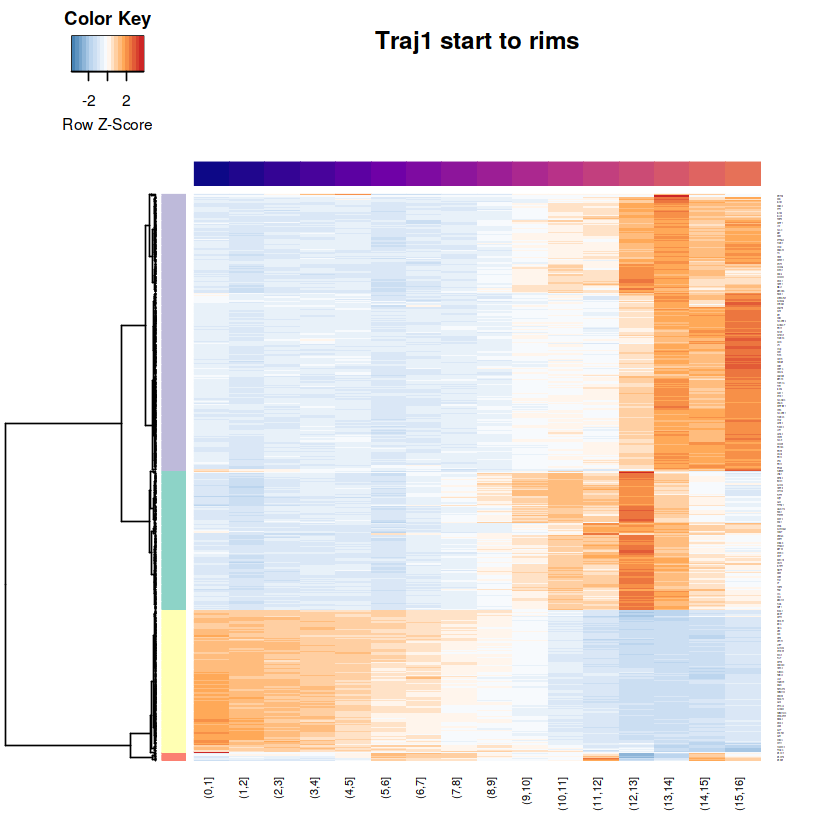

In [36]:
#pseudotime_colfunc <- colorRampPalette(c("lightgrey", "lemonchiffon1", "lemonchiffon2","tan1", "firebrick2", "firebrick3"))             
pseudotime_colfunc <- colorRampPalette(c("#0d0887", "#6c00a8", "#b52e8c","#e3695e", "#fcab33", "#f3f027"))             

#-------------------------------- plot the heatmap -----------------------------------------------------#
column_colors_use <- pseudotime_colfunc(25)[1:length(colnames(agg_mat))]
names(column_colors_use) = colnames(agg_mat)
#column_colors_use


heatmap.2(as.matrix(agg_mat),
          col=colfunc(20),
          keysize = 1,
          scale="row", 
          trace="none",
          Rowv=as.dendrogram(hr),
          cexRow = 0.1, 
          cexCol = 0.8,
          RowSideColors = RowSideColors,
          ColSideColors = column_colors_use,
          #labRow = c("SPP1"), #optional, if want to highlight or search for a gene (since it's hard to read)
          Colv = "NA", # do unsupervised
          main = "Traj1 start to rims",
          dendrogram = 'row', # remove row dendrogram
          density.info="none",  
          )


### 2. Subtrajectory 2 (ends at active cores)

#### Load in object and DEGs

In [11]:
### load data
DEGs <- read.csv(paste0(indir, "1.DE_results_subtraj_4-1.startnode_to_infl_allgenes.csv"
                       ), row.names = 1)
head(DEGs)

cds <- readRDS("RData/monocle3/subtraj_4-1.startnode_to_infl_graph.rds")
#cds <- readRDS("RData/monocle3/subtraj_4-1.startnode_to_infl_graph.rds")
print("number of spots")
ncol(cds)


,status,p_value,morans_test_statistic,morans_I,gene_short_name,q_value
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
MIR1302-2HG,FAIL,NA,NA,NA,MIR1302-2HG,1.0000000
FAM138A,FAIL,NA,NA,NA,FAM138A,1.0000000
OR4F5,FAIL,NA,NA,NA,OR4F5,1.0000000
AL627309.1,OK,0.7559877,-0.6934541,-0.001433606,AL627309.1,0.8113257
AL627309.3,FAIL,NA,NA,NA,AL627309.3,1.0000000
AL627309.2,FAIL,NA,NA,NA,AL627309.2,1.0000000


[1] "number of spots"


[1] 18154

In [12]:

### select only significant genes
print("Filter significant DEGs")
DEGs <- DEGs[DEGs$status == "OK" , ] # optional. doesn't matter. all q-values < 0.01 have status OK
nrow(DEGs)
DEGs <- subset(DEGs, q_value < 0.001) # of 0.05
print('with these thresholds, there are:')
nrow(DEGs)
print('significant DEGs')
DEGs <- DEGs[order(DEGs$morans_I, decreasing = TRUE),] #order

[1] "Filter significant DEGs"


[1] 23809

[1] "with these thresholds, there are:"


[1] 4133

[1] "significant DEGs"


In [14]:
# input is 500 significant DEGs, ordered by effect size
top_ids <- rownames(DEGs[1:500,])
top_ids

[1] "PLP1"       "MBP"        "HBA1"       "HBA2"       "HBB"       
  [6] "CNP"        "IGHG1"      "IGHG3"      "DCN"        "TF"        
 [11] "IGLC2"      "APLP1"      "MOBP"       "ACTA2"      "CLDND1"    
 [16] "MYL9"       "MARCKSL1"   "IGKC"       "MYH11"      "CLDN5"     
 [21] "PPP1R14A"   "FTH1"       "JCHAIN"     "TAGLN"      "MAG"       
 [26] "VIM"        "GJA1"       "COL1A2"     "IGHGP"      "MGP"       
 [31] "CLU"        "AQP4"       "ERMN"       "CRYAB"      "IGLC3"     
 [36] "SCD"        "C7"         "VWF"        "TGM2"       "STMN1"     
 [41] "S100B"      "MZB1"       "CYP1B1"     "TPM2"       "CLDN11"    
 [46] "HLA-B"      "MOG"        "EPAS1"      "IFI27"      "TUBA1A"    
 [51] "EDIL3"      "CCL5"       "ENPP2"      "CNTN2"      "TMSB10"    
 [56] "CPE"        "SEPT4"      "FRZB"       "IGFBP7"     "GPNMB"     
 [61] "NOTCH3"     "CARNS1"     "PTGDS"      "STMN4"      "FBLN1"     
 [66] "TM4SF1"     "ITM2A"      "CFH"        "A2M"        "FN1"       
 [71] "UGT8"       "ACTG2"      "TIMP3"      "TMEM144"    "KLK6"      
 [76] "MT-ND2"     "C1S"        "PRELP"      "AGT"        "C11orf96"  
 [81] "IGFBP4"     "RGS5"       "SPP1"       "HAPLN2"     "MAL"       
 [86] "CEMIP"      "EFEMP1"     "HLA-C"      "FAM107A"    "QDPR"      
 [91] "MT-ND1"     "APOE"       "ESAM"       "KLF2"       "TRBC2"     
 [96] "PLLP"       "GNG11"      "IGFBP2"     "BCAS1"      "APOC1"     
[101] "FEZ1"       "B2M"        "TUBB4A"     "FBLN2"      "IFITM3"    
[106] "PODXL"      "HSPA2"      "RAPGEF5"    "IGHG4"      "PLN"       
[111] "PLEKHB1"    "ABCA2"      "SPARCL1"    "APOD"       "DTNA"      
[116] "MT-CO2"     "EGFL7"      "SIRT2"      "GPM6A"      "MAOB"      
[121] "GFAP"       "LTF"        "FLNA"       "AQP1"       "FLT1"      
[126] "HLA-A"      "CNDP1"      "ABCG2"      "CD74"       "PIP4K2A"   
[131] "AEBP1"      "CAMK2N1"    "ZFP36L1"    "HLA-DRA"    "IGFBP6"    
[136] "ENG"        "HLA-E"      "HSPB1"      "CD44"       "SEPT8"     
[141] "MT-ND4"     "PAQR6"      "LHPP"       "SLAIN1"     "NR2F2"     
[146] "MT-CO1"     "ELOVL1"     "S100A6"     "C4orf48"    "CP"        
[151] "MYRF"       "CD79A"      "CASQ2"      "MT-ND3"     "HLA-DRB1"  
[156] "MGST1"      "SLC2A1"     "THBS1"      "ANLN"       "ATP1B1"    
[161] "ITIH5"      "AHNAK"      "SEMA4D"     "PLEKHH1"    "CDKN1C"    
[166] "DHCR24"     "CNN1"       "GPM6B"      "OLIG1"      "ICAM2"     
[171] "SERPING1"   "CST3"       "LGALS3"     "GPRC5B"     "RNASE1"    
[176] "OGN"        "TIMP1"      "SPOCK3"     "TRAC"       "SRGN"      
[181] "MT-ATP6"    "NEAT1"      "S100A10"    "CXCL12"     "SLAMF7"    
[186] "TSC22D4"    "FA2H"       "IGHG2"      "TPPP"       "TMEM151A"  
[191] "COL3A1"     "TPM1"       "C1R"        "NKX6-2"     "CMTM5"     
[196] "FTL"        "GJB1"       "SELENOP"    "LUM"        "CAVIN2"    
[201] "NR4A1"      "CTGF"       "GPR37"      "LANCL1"     "BACE1"     
[206] "NTRK2"      "SLC14A1"    "ITM2C"      "CD24"       "ATP1A2"    
[211] "ACKR1"      "FIS1"       "IGFBP3"     "HIGD1B"     "ANXA1"     
[216] "TTYH2"      "MT2A"       "HLA-DPA1"   "IGHM"       "RASSF2"    
[221] "C3"         "FOXC1"      "GZMK"       "PECAM1"     "HERPUD1"   
[226] "FGFR2"      "MALAT1"     "WLS"        "CCL19"      "SLC12A2"   
[231] "IFITM2"     "MT3"        "OPALIN"     "AL078639.1" "TPT1"      
[236] "PSAP"       "CTSS"       "HLA-DPB1"   "FKBP11"     "CD52"      
[241] "APOLD1"     "EVI2A"      "DUSP1"      "CEBPD"      "PDLIM1"    
[246] "MAPK8IP1"   "BST2"       "DCLK1"      "ANXA2"      "NDUFA4L2"  
[251] "CD8A"       "DPYSL2"     "TRBC1"      "CTSB"       "ABCB1"     
[256] "CDH5"       "C1QB"       "CALD1"      "ISLR"       "IFI6"      
[261] "PLA2G16"    "PCSK6"      "SELENOW"    "IL7R"       "IFI44L"    
[266] "ID1"        "MYH9"       "SMOC2"      "CDK18"      "ITIH2"     
[271] "TINAGL1"    "PCAT19"     "NECAB1"     "B3GAT1"     "GNAI1"     
[276] "AATK"       "PDGFRB"     "CYBA"       "LAMB1"      "EEF1A1"    
[281] "ADGRF5"     "BOK"  

In [15]:
# decision: which pseudotime breaks?
cds$pseudotime_bins <- cut(cds$Pseudotime, breaks = as.vector(seq(0,round(max(cds$Pseudotime)),1)))

# make a heatmap matrix
cell_group_df <- tibble::tibble(cell=row.names(colData(cds)), 
                                cell_group=cds$pseudotime_bins)
agg_mat <- aggregate_gene_expression(cds, gene_group_df = NULL, cell_group_df = cell_group_df)

dim(agg_mat)
agg_mat <- agg_mat[rownames(agg_mat) %in% top_ids ,]

# order the columns
agg_mat <- agg_mat[, match( levels(cds$pseudotime_bins), colnames(agg_mat))]
dim(agg_mat)
head(agg_mat)

[1] 33538    20

[1] 500  20

,"(0,1]","(1,2]","(2,3]","(3,4]","(4,5]","(5,6]","(6,7]","(7,8]","(8,9]","(9,10]","(10,11]","(11,12]","(12,13]","(13,14]","(14,15]","(15,16]","(16,17]","(17,18]","(18,19]","(19,20]"
PADI2,1.5178240,1.2744427,1.4838292,1.2823567,1.0546720,0.5350229,0.4968050,0.4224032,0.43988579,0.14469159,-0.11769614,-0.58986463,-0.9424881,-0.7991546,-0.9177446,-0.9542299,-1.25883559,-1.5002410,-1.2734608,-0.29821767
CAMK2N1,1.3708355,1.1554071,1.3053571,1.2002646,1.0726101,0.9749570,0.6715661,0.6059078,0.26798893,0.22272552,-0.23924970,-0.66212228,-0.9316917,-1.1795174,-1.2596296,-0.9509364,-1.17790733,-1.3291139,-1.0955715,-0.02187985
C1QA,-0.8602273,-1.0299673,-0.8109773,-0.5694908,-0.7326874,-1.1951949,-1.4108543,-0.8361355,-0.57230816,-0.05052917,0.08905479,0.01456806,0.1428377,0.8790190,1.0291106,0.8779043,2.44582209,0.5870142,1.3678574,0.63518394
C1QB,-1.0061894,-0.9775171,-0.8519077,-1.0529066,-0.8642252,-1.1653225,-0.8980978,-1.0063284,-0.41755480,0.27312074,0.44505503,0.12301559,0.6554831,1.2961462,1.4206512,1.1264463,2.17866157,-0.2682240,0.7254448,0.26424899
ID3,-1.0941146,-1.2311118,-1.0172945,-0.8624264,-0.8360299,-1.2382120,-1.0207834,-0.7755121,-0.05481698,0.23993474,0.53410777,0.17454507,0.4916528,1.5521915,1.0975108,0.3495613,0.05240197,1.0220097,2.2592541,0.35713200
RPL11,-0.4598363,-1.0351582,-0.8158554,-0.8094432,-0.7691059,-1.1451374,-0.9349029,-0.8593337,-0.61410181,-0.25952581,-0.15445284,-0.23067699,0.2793403,0.8284504,1.4813261,0.9845554,2.25438914,0.0108184,1.7648861,0.48376466


#### Make heatmap with pseudotime bins 

In [17]:
# cluster the genes
hr <- hclust(as.dist(1-cor(t(as.matrix(agg_mat)), method="pearson")), method="ward.D2") # tree of the genes
# decide on the number of clusters
my_height <- 3
clusters <- cutree(hr, h = my_height) # the lower the more clusters
print("gene clusters found")
print(unique(clusters))

[1] "gene clusters found"
[1] 1 2 3 4 5


In [18]:
### map clusters to colors
colors <- brewer.pal(n = length(unique(clusters)), name = "Set3")
RowSideColors <- plyr:::mapvalues(from = unique(clusters), to = colors, clusters)

# heatmapcolors
colfunc <- colorRampPalette(c("steelblue", "slategray2", "white", "tan1", "firebrick3"))

### store the clusters
gene_list <- list()
for (i in 1:length(unique(RowSideColors))){
    gene_list[[i]] <- names(RowSideColors[RowSideColors == unique(RowSideColors)[i]])
    names(gene_list)[i] <- unique(RowSideColors)[i]
}

gene_clusters <- data.frame(gene_list[[1]])
for (i in 2:length(gene_list)){
    gene_clusters <- qpcR:::cbind.na(gene_clusters, gene_list[[i]])
}

names(gene_list)

colnames(gene_clusters) <- names(gene_list)

[1] "#8DD3C7" "#FFFFB3" "#BEBADA" "#FB8072" "#80B1D3"

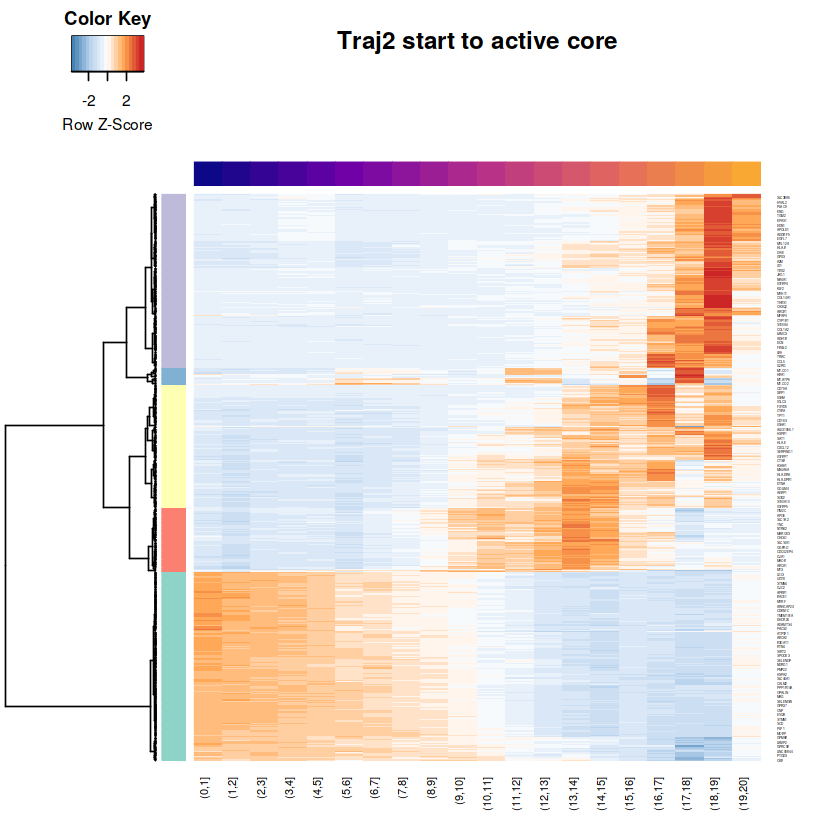

In [21]:
#pseudotime_colfunc <- colorRampPalette(c("lightgrey", "lemonchiffon1", "lemonchiffon2","tan1", "firebrick2", "firebrick3"))             
pseudotime_colfunc <- colorRampPalette(c("#0d0887", "#6c00a8", "#b52e8c","#e3695e", "#fcab33", "#f3f027"))             
#colfunc(25)

#-------------------------------- plot the heatmap -----------------------------------------------------#
column_colors_use <- pseudotime_colfunc(25)[1:length(colnames(agg_mat))]
names(column_colors_use) = colnames(agg_mat)
#column_colors_use


heatmap.2(as.matrix(agg_mat),
          col=colfunc(20),
          keysize = 1,
          scale="row", 
          trace="none",
          Rowv=as.dendrogram(hr),
          cexRow = 0.2, 
          cexCol = 0.8,
          RowSideColors = RowSideColors,
          #labRow = c("IGKC"), #optional, if want to highlight or search for a gene (since it's hard to read)
          main = "Traj2 start to active core",
          ColSideColors = column_colors_use,
          Colv = "NA", # do unsupervised
          dendrogram = 'row', # remove row dendrogram
          density.info="none",  
          )


### 3. Subtrajectory 3 (ends at mixed cores)

#### Load in object and DEGs

In [22]:
### load data
DEGs <- read.csv(paste0(indir, "1.DE_results_subtraj_4-2.startnode_to_active_mixed_allgenes.csv"
                       ), row.names = 1)
head(DEGs)

cds <- readRDS("RData/monocle3/subtraj_4-2.startnode_to_active_mixed_graph.rds")
#cds <- readRDS("RData/monocle3/subtraj_4-1.startnode_to_infl_graph.rds")
print("number of spots")
ncol(cds)


,status,p_value,morans_test_statistic,morans_I,gene_short_name,q_value
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
MIR1302-2HG,FAIL,NA,NA,NA,MIR1302-2HG,1.0000000
FAM138A,FAIL,NA,NA,NA,FAM138A,1.0000000
OR4F5,FAIL,NA,NA,NA,OR4F5,1.0000000
AL627309.1,OK,0.6923502,-0.502523,-0.000978364,AL627309.1,0.7574733
AL627309.3,FAIL,NA,NA,NA,AL627309.3,1.0000000
AL627309.2,FAIL,NA,NA,NA,AL627309.2,1.0000000


[1] "number of spots"


[1] 20717

In [23]:

### select only significant genes
print("Filter significant DEGs")
DEGs <- DEGs[DEGs$status == "OK" , ] # optional. doesn't matter. all q-values < 0.01 have status OK
nrow(DEGs)
DEGs <- subset(DEGs, q_value < 0.001) # of 0.05
print('with these thresholds, there are:')
nrow(DEGs)
print('significant DEGs')
DEGs <- DEGs[order(DEGs$morans_I, decreasing = TRUE),] #order

[1] "Filter significant DEGs"


[1] 23635

[1] "with these thresholds, there are:"


[1] 5842

[1] "significant DEGs"


#### Make heatmap with pseudotime bins 

In [24]:
# input is 500 significant DEGs, ordered by effect size
top_ids <- rownames(DEGs[1:500,])
top_ids

[1] "CNP"        "MBP"        "PLP1"       "MT-ND1"     "MT-ND2"    
  [6] "MT-CO1"     "TF"         "MT-ND4"     "APLP1"      "MT-ND3"    
 [11] "MT-ATP6"    "MOBP"       "CLDND1"     "PTGDS"      "PPP1R14A"  
 [16] "MT-CO2"     "FTH1"       "MAG"        "MARCKSL1"   "MT-CYB"    
 [21] "SPP1"       "S100B"      "CLDN11"     "STMN1"      "SCD"       
 [26] "MT-CO3"     "TUBA1A"     "ERMN"       "EDIL3"      "ENPP2"     
 [31] "APOD"       "SEPT4"      "RPL37A"     "RPL41"      "QDPR"      
 [36] "CNTN2"      "MT-ND4L"    "TMSB4X"     "CRYAB"      "TMEM144"   
 [41] "MT-ND5"     "MAL"        "MOG"        "FEZ1"       "CARNS1"    
 [46] "APOE"       "RNASE1"     "ACTB"       "GAPDH"      "RPS12"     
 [51] "SELENOP"    "HSPA2"      "RPL37"      "DPYSL2"     "RPS18"     
 [56] "RPL10"      "RPLP1"      "ITM2B"      "TSC22D4"    "RPL32"     
 [61] "GPRC5B"     "ABCA2"      "RPL28"      "PIP4K2A"    "PLLP"      
 [66] "UBB"        "SIRT2"      "STMN4"      "KLK6"       "PLEKHB1"   
 [71] "BCAS1"      "C4orf48"    "RPS15"      "RPL13A"     "RPL38"     
 [76] "AL078639.1" "RPL34"      "UGT8"       "RPL19"      "PSAP"      
 [81] "RPL26"      "CLU"        "RPL30"      "RPS8"       "AQP4"      
 [86] "RPS29"      "RPS27A"     "SLAIN1"     "GJA1"       "HAPLN2"    
 [91] "TUBB4A"     "SELENOW"    "CALM2"      "PTMA"       "GSN"       
 [96] "SEPT8"      "LHPP"       "RPS27"      "MALAT1"     "ATP1B1"    
[101] "CSRP1"      "RPS14"      "RPL23A"     "EEF1A1"     "RAPGEF5"   
[106] "RPL21"      "RPL9"       "OLIG1"      "FAU"        "RPS23"     
[111] "PAQR6"      "CAMK2N1"    "ELOVL1"     "RPL13"      "RPS13"     
[116] "MT-ATP8"    "MT3"        "PEBP1"      "RPS6"       "FIS1"      
[121] "ATP5ME"     "RPLP2"      "ANLN"       "PMP22"      "MYRF"      
[126] "HSP90AA1"   "PPIA"       "LAMP2"      "RPL4"       "VIM"       
[131] "RPS25"      "EVI2A"      "TPT1"       "RPL31"      "QKI"       
[136] "CPE"        "GPM6B"      "NKX6-2"     "TTYH2"      "TPPP"      
[141] "PLEKHH1"    "CNDP1"      "CD74"       "PLA2G16"    "AGT"       
[146] "EFHD1"      "RPS9"       "IGLC2"      "CKB"        "RPS24"     
[151] "SEMA4D"     "RPS16"      "YWHAQ"      "RPS26"      "CDKN1C"    
[156] "RPS11"      "GLUL"       "ACTG1"      "LANCL1"     "ITM2C"     
[161] "RPL27A"     "FTL"        "NENF"       "ATP5F1E"    "CD81"      
[166] "SPOCK3"     "RPS3"       "RPL35"      "RPL15"      "RASSF2"    
[171] "RPS20"      "C3"         "HTRA1"      "SLC44A1"    "RPS21"     
[176] "FGFR2"      "SCD5"       "DHCR24"     "RPS19"      "FA2H"      
[181] "APOC1"      "GPR37"      "CMTM5"      "RPL3"       "AQP1"      
[186] "MAPK8IP1"   "IGHG1"      "RPL18"      "CFL1"       "RPS28"     
[191] "PADI2"      "BACE1"      "RTN4"       "FAM107A"    "BIN1"      
[196] "RPL39"      "RPSA"       "EFEMP1"     "TMEM151A"   "UBA52"     
[201] "IGHG3"      "GPNMB"      "NDRG1"      "IGFBP7"     "FAM107B"   
[206] "C1orf122"   "RPL8"       "APP"        "S100A6"     "CBR1"      
[211] "SORT1"      "CD9"        "RPL7A"      "SOX8"       "RPS2"      
[216] "EIF1"       "RPS3A"      "OPALIN"     "SLC12A2"    "BOK"       
[221] "RPL12"      "RPL18A"     "H3F3B"      "LPAR1"      "IGKC"      
[226] "B2M"        "CST3"       "GJB1"       "HLA-DRA"    "RPL35A"    
[231] "SPARCL1"    "SYT11"      "SERF2"      "PEA15"      "SEMA3B"    
[236] "RPS15A"     "SLC48A1"    "TBCB"       "AATK"       "LTF"       
[241] "PCSK6"      "RPL36A"     "GNAI1"      "FMNL2"      "RPL24"     
[246] "CDK18"      "C1orf61"    "COX6A1"     "RPS10"      "RPL6"      
[251] "NDUFA4"     "B3GAT1"     "TMEM59"     "SECISBP2L"  "RPL23"     
[256] "LGI3"       "AMER2"      "RPL22"      "RPL36"      "RPS4X"     
[261] "COX4I1"     "CTSD"       "RPL29"      "SEPT7"      "RNF130"    
[266] "CD63"       "TTYH1"      "RHOU"       "MAOB"       "RPLP0"     
[271] "RPS5"       "TUBA1B"     "GFAP"       "TPPP3"      "RTN3"      
[276] "RPL27"      "APBB1"      "LGALS1"     "SHTN1"      "DBI"       
[281] "CERS2"      "HSPB1"

In [25]:
# decision: which pseudotime breaks?
cds$pseudotime_bins <- cut(cds$Pseudotime, breaks = as.vector(seq(0,round(max(cds$Pseudotime)),1)))

# make a heatmap matrix
cell_group_df <- tibble::tibble(cell=row.names(colData(cds)), 
                                cell_group=cds$pseudotime_bins)
agg_mat <- aggregate_gene_expression(cds, gene_group_df = NULL, cell_group_df = cell_group_df)

dim(agg_mat)
agg_mat <- agg_mat[rownames(agg_mat) %in% top_ids ,]

# order the columns
agg_mat <- agg_mat[, match( levels(cds$pseudotime_bins), colnames(agg_mat))]
dim(agg_mat)
head(agg_mat)

[1] 33538    23

[1] 500  23

,"(0,1]","(1,2]","(2,3]","(3,4]","(4,5]","(5,6]","(6,7]","(7,8]","(8,9]","(9,10]",⋯,"(13,14]","(14,15]","(15,16]","(16,17]","(17,18]","(18,19]","(19,20]","(20,21]","(21,22]","(22,23]"
VWA1,1.5579511,1.2999358,1.2392862,1.1812808,1.2081160,0.9593566,0.7854463,0.8158207,0.4951980,0.4745394,⋯,-0.1537740,-0.6520640,-0.71162623,-0.9144118,-1.1149608,-1.0340721,-1.1280618,-1.262989,-1.317971,-1.339106
RPL22,0.5226247,0.1727174,0.6654631,0.6650229,0.5341089,0.3509707,0.4863341,0.3844127,0.3626616,0.6892099,⋯,0.8775488,0.5821900,0.14740334,-0.1977433,-0.2214558,-0.4190013,-0.8822172,-1.351472,-2.689465,-2.622713
ENO1,0.1250021,-0.1698242,0.1169989,0.4486878,0.2592956,-0.5018090,-0.1021610,0.7879202,1.2625764,1.5337085,⋯,1.3629490,0.5095353,-0.01485795,-0.2635693,-0.6550121,-0.9504925,-0.9997446,-1.288406,-2.174986,-1.820785
PADI2,1.4834749,1.3003730,1.4578998,1.3063269,1.1350339,0.7440887,0.7153365,0.6593621,0.6725147,0.4504326,⋯,-0.2765746,-0.5471453,-0.83951934,-0.9447666,-0.8624783,-1.0074156,-1.1551729,-1.245803,-1.448376,-1.380951
CAMK2N1,1.4367207,1.2569617,1.3820839,1.2943919,1.1878737,1.1063894,0.8532321,0.7984452,0.5164769,0.4787079,⋯,-0.6759345,-0.7594511,-0.72931579,-0.8776138,-0.8011994,-0.8129796,-1.0322050,-1.338595,-1.332603,-1.300410
C1QB,-0.2972952,-0.2661118,-0.1295016,-0.3481038,-0.1428979,-0.4703650,-0.1797370,-0.2974464,0.3428916,1.0940560,⋯,2.1633515,1.1742272,0.20133667,-0.4996715,-0.5213782,-0.2062243,-0.4236480,-1.199278,-2.021037,-1.694926


In [26]:
# cluster the genes
hr <- hclust(as.dist(1-cor(t(as.matrix(agg_mat)), method="pearson")), method="ward.D2") # tree of the genes
# decide on the number of clusters
my_height <- 2
clusters <- cutree(hr, h = my_height) # the lower the more clusters
print("gene clusters found")
print(unique(clusters))

[1] "gene clusters found"
[1] 1 2 3 4 5 6


In [27]:
### map clusters to colors
colors <- brewer.pal(n = length(unique(clusters)), name = "Set3")
RowSideColors <- plyr:::mapvalues(from = unique(clusters), to = colors, clusters)

# heatmapcolors
colfunc <- colorRampPalette(c("steelblue", "slategray2", "white", "tan1", "firebrick3"))

### store the clusters
gene_list <- list()
for (i in 1:length(unique(RowSideColors))){
    gene_list[[i]] <- names(RowSideColors[RowSideColors == unique(RowSideColors)[i]])
    names(gene_list)[i] <- unique(RowSideColors)[i]
}

gene_clusters <- data.frame(gene_list[[1]])
for (i in 2:length(gene_list)){
    gene_clusters <- qpcR:::cbind.na(gene_clusters, gene_list[[i]])
}

names(gene_list)

colnames(gene_clusters) <- names(gene_list)

[1] "#8DD3C7" "#FFFFB3" "#BEBADA" "#FB8072" "#80B1D3" "#FDB462"

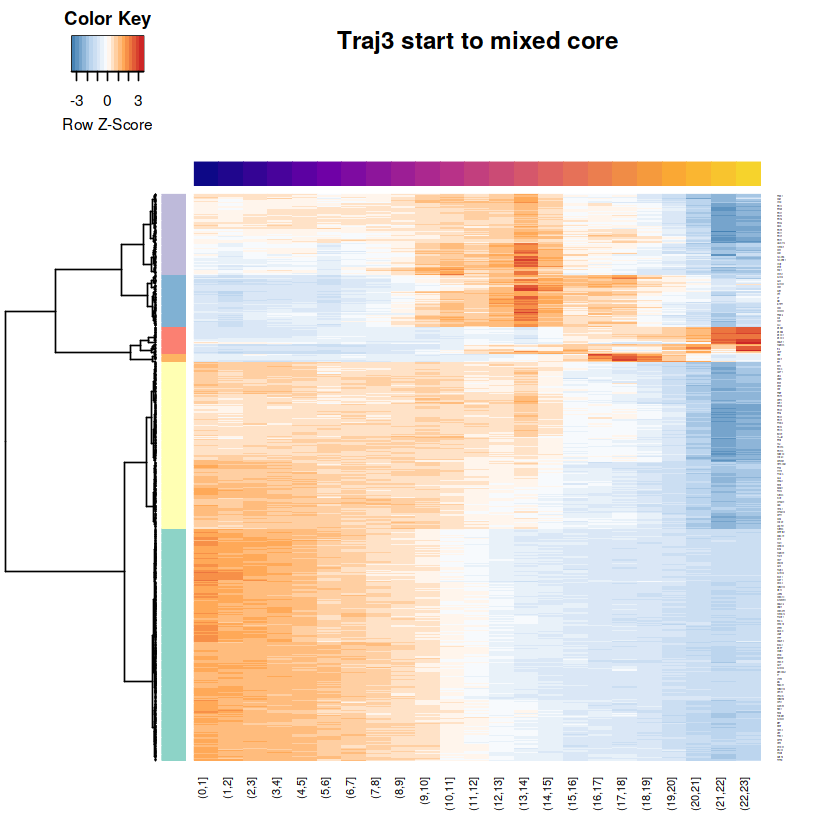

In [28]:
pseudotime_colfunc <- colorRampPalette(c("#0d0887", "#6c00a8", "#b52e8c","#e3695e", "#fcab33", "#f3f027"))             

#-------------------------------- plot the heatmap -----------------------------------------------------#
column_colors_use <- pseudotime_colfunc(25)[1:length(colnames(agg_mat))]
names(column_colors_use) = colnames(agg_mat)

heatmap.2(as.matrix(agg_mat),
          col=colfunc(20),
          keysize = 1,
          scale="row", 
          trace="none",
          Rowv=as.dendrogram(hr),
          main = "Traj3 start to mixed core",
          cexRow = 0.1, 
          cexCol = 0.8,
          RowSideColors = RowSideColors,
          ColSideColors = column_colors_use,
          #labRow = c("IGKC"), #optional, if want to highlight or search for a gene (since it's hard to read)
          Colv = "NA", # do unsupervised
          dendrogram = 'row', # remove row dendrogram
          density.info="none",  
          )


In [10]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /data/bcn/p310674/anaconda3/envs/R_monocle/lib/libopenblasp-r0.3.23.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Amsterdam
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] qpcR_1.4-1                  robustbase_0.99-2          
 [3] rgl_1.2.8                   minpack.lm_1.2-4           
 [5] MASS_7.3-60                 gplots_3.1.3               
 [7] RColorBrewer